# Predict house price in Warsaw using PyTorch


### Import necessary libraries

In [399]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import torch

### Load and analyze the dataset
Visualize what's inside the dataset. 

What type of data are we looking at.

Display charts, dependencies and check if dataset is clean.

In [400]:
df = pd.read_csv("../datasets/warsaw_houses.csv")

In [401]:
df.head()

,district,rooms,square_meters,price
0,Wola,1,29.0,2300
1,Bemowo,3,61.0,3300
2,Ursynów,3,68.0,3499
3,Śródmieście,3,172.0,40000
4,PragaPółnoc,2,40.0,2500


In [402]:
df.shape

(1038, 4)

In [403]:
df.describe()

,rooms,square_meters,price
count,1038.000000,1038.000000,1038.000000
mean,2.301541,58.238834,5999.289981
std,0.874264,32.275873,15918.373740
min,1.000000,17.290000,1700.000000
25%,2.000000,39.700000,3000.000000
50%,2.000000,49.800000,3600.000000
75%,3.000000,66.000000,5000.000000
max,6.000000,328.000000,249990.000000


In [404]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   district       1038 non-null   object 
 1   rooms          1038 non-null   int64  
 2   square_meters  1038 non-null   float64
 3   price          1038 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 32.6+ KB


### Explore data with charts

In [405]:
# Collect mean prices for houses in each city district
unique_districts = df['district'].unique()
mean_prices = []

for d in unique_districts:
    single_district = df[df['district'] == d]
    mean_price = single_district['price'].mean()
    mean_prices.append(mean_price)

# Sort from most expensive to the least expensive
districts_prices = sorted(zip(unique_districts, mean_prices), key=lambda pair: pair[1], reverse=True)
districts, prices = zip(*districts_prices)

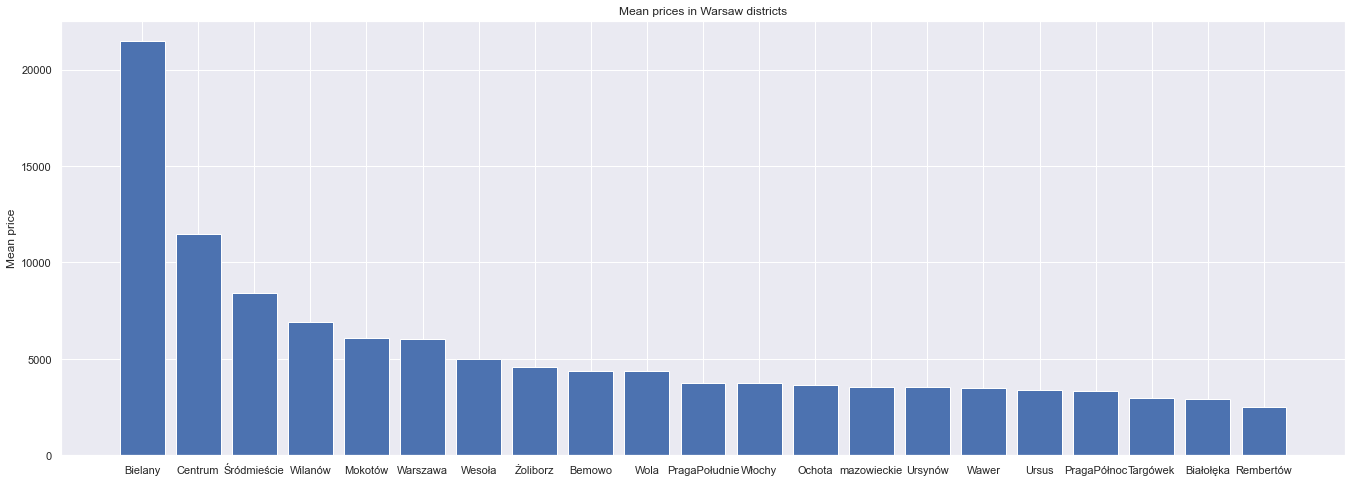

In [406]:
# Show prices in the chart
fig, ax = plt.subplots(figsize=(23,8))

ax.bar(districts, prices)

ax.set_ylabel('Mean price')
ax.set_title('Mean prices in Warsaw districts')

plt.show()

In [407]:
sorted_by_sqm = df.sort_values('square_meters')
sorted_by_sqm.head()

,district,rooms,square_meters,price
397,Włochy,1,17.29,2500
382,Włochy,1,17.29,2500
818,Włochy,1,17.29,2500
35,Ochota,1,18.00,1700
557,Żoliborz,1,20.00,2200


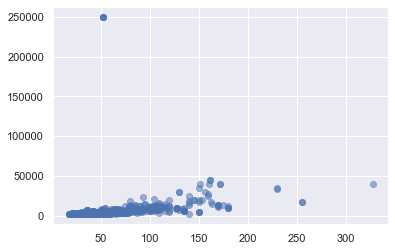

In [408]:
plt.scatter(sorted_by_sqm['square_meters'], sorted_by_sqm['price'], alpha=0.5)
plt.show()

In [409]:
df = df.drop(df[(df['rooms'] == 2)  & (df['price']>50000)].index)

In [410]:
# Count houses number for each district
houses_count = []
for d in districts:
    single_district = df[df['district'] == d]
    houses_count.append(len(single_district))


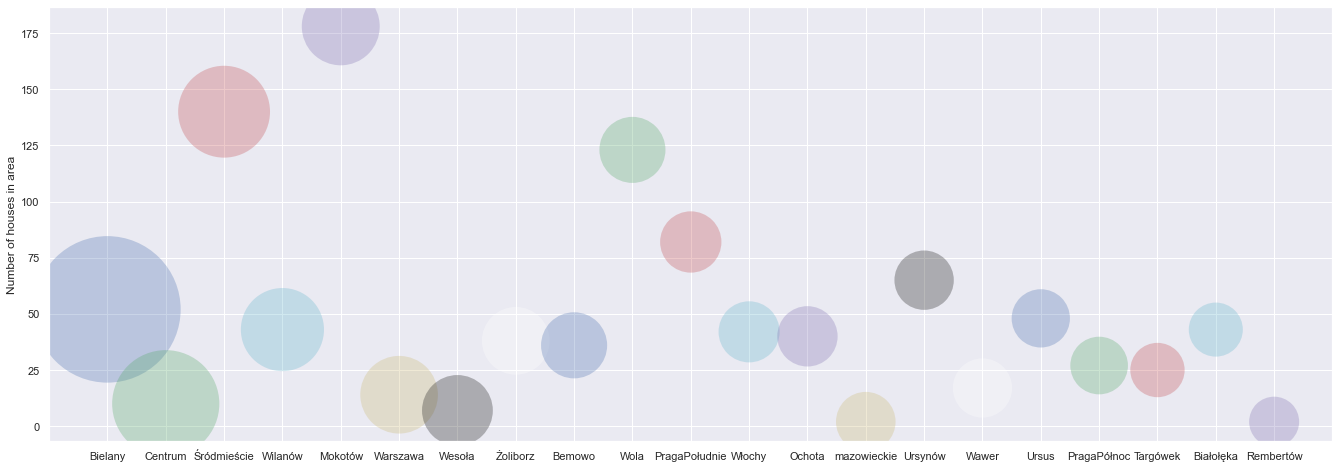

In [411]:
# Let's see a scatterplot to check how
colors = list("bgrcmykw")*3
colors = colors[:len(districts)]

fig, ax = plt.subplots(figsize=(23,8))

ax.scatter(districts, houses_count, c=colors, s=prices, alpha=0.3, edgecolors='none')
ax.set_ylabel('Number of houses in area')
ax.grid(True)

plt.show()

### Try to find outliers in the feature columns

In [412]:
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler # Standardization
from sklearn.ensemble import IsolationForest # Outlier Detection

Text(0.5, 0.98, 'rooms Analysis')

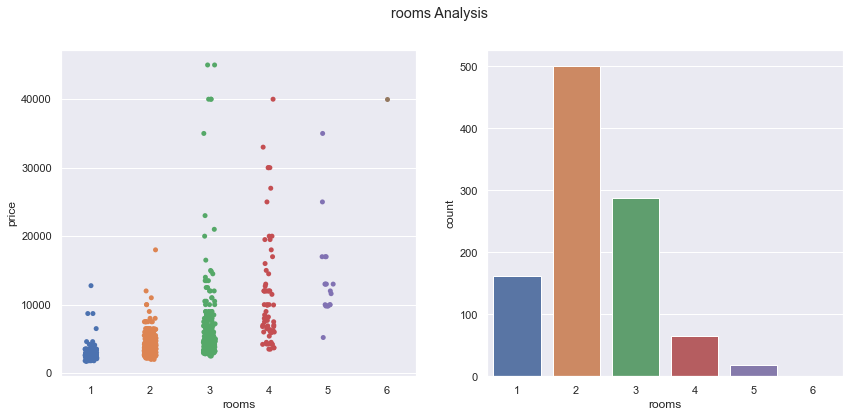

In [413]:
fig, ax = plt.subplots(1,2,figsize=(14,6))
sns.stripplot(x='rooms', y='price', data=df, ax=ax[0])
sns.countplot(df['rooms'], ax=ax[1])
fig.suptitle(str('rooms') + ' Analysis')

In [414]:
df = df.drop(df[df['square_meters'] > 200].index)
df = df.drop(df[df['price'] > 30_000].index)

Text(0.5, 0.98, 'square_meters Analysis')

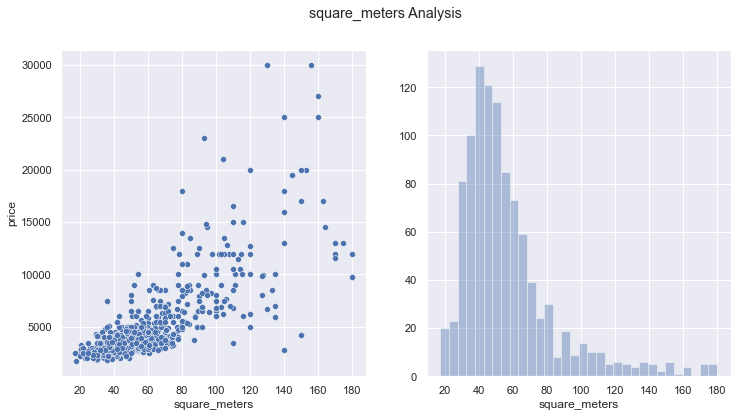

In [415]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
sns.scatterplot(x='square_meters', y='price', data=df, ax=ax[0])
sns.distplot(df['square_meters'], kde=False, ax=ax[1])
fig.suptitle(str('square_meters') + ' Analysis')

In [416]:
# Remove rows with 'mazowieckie' district as it is not a valid district
df = df.drop(df[(df.district == "mazowieckie") | (df.district == "Warszawa")].index)

### Preparation for model training

In [417]:
# Use OrdinalEncoding to encode categorical values to numerical ones
enc = OrdinalEncoder()
enc.fit(df[['district']])
print(enc.categories_)

df[['district']] = enc.transform(df[['district']])
df.head()

[array(['Bemowo', 'Białołęka', 'Bielany', 'Centrum', 'Mokotów', 'Ochota',
       'PragaPołudnie', 'PragaPółnoc', 'Rembertów', 'Targówek', 'Ursus',
       'Ursynów', 'Wawer', 'Wesoła', 'Wilanów', 'Wola', 'Włochy',
       'Śródmieście', 'Żoliborz'], dtype=object)]


,district,rooms,square_meters,price
0,15.0,1,29.0,2300
1,0.0,3,61.0,3300
2,11.0,3,68.0,3499
4,7.0,2,40.0,2500
5,1.0,2,40.0,2200


<AxesSubplot:>

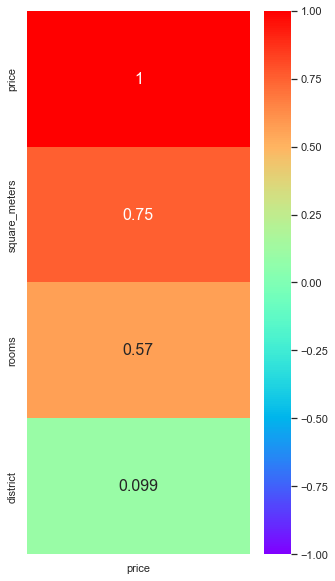

In [497]:
top_features = df.corr()[['price']].sort_values(by=['price'],ascending=False).head(30)
plt.figure(figsize=(5,10))
sns.heatmap(top_features,cmap='rainbow',annot=True,annot_kws={"size": 16},vmin=-1)

In [419]:
df.head()

,district,rooms,square_meters,price
0,15.0,1,29.0,2300
1,0.0,3,61.0,3300
2,11.0,3,68.0,3499
4,7.0,2,40.0,2500
5,1.0,2,40.0,2200


In [420]:
# Separate features from prices
house_features = df.loc[:, df.columns != "price"]
house_prices = df['price']

In [421]:
# Prepare train and test sets
X_train, x_test, Y_train, y_test = train_test_split(house_features, house_prices, test_size=0.2, random_state=42)

In [422]:
# Data standarization
scaler = StandardScaler()
# fit scaler on data
X_train_norm = scaler.fit_transform(X_train)
X_train_norm[:5]

array([[ 1.30609112, -0.34969023, -0.4677868 ],
       [ 0.44380071,  0.8169112 , -0.0404722 ],
       [ 1.30609112,  0.8169112 , -0.4677868 ],
       [ 0.96117495, -0.34969023, -0.7526632 ],
       [ 1.30609112,  0.8169112 ,  1.52634799]])

### Decision Tree 

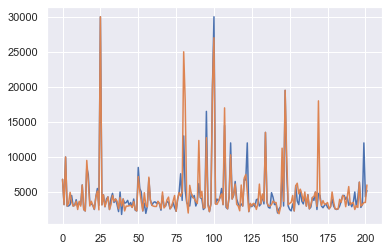

In [451]:
from sklearn.tree import DecisionTreeRegressor

# Fit regression model
regr = DecisionTreeRegressor(max_depth=12, criterion="squared_error")
regr.fit(X_train, Y_train)

# Predict
result = regr.predict(x_test.to_numpy())

# Plot results
plt.plot(y_test.to_numpy())
plt.plot(result)
plt.show()

In [447]:
index = 1
res = regr.predict([x_test.to_numpy()[index]])
print(f"Predicted: {res}")
print(f"Expected result: {y_test.to_numpy()[index]}")

Predicted: [3199.]
Expected result: 3199


In [448]:
print(f"R2: {regr.score(x_test, y_test)}")
print(f"MAE: {mean_absolute_error(y_test, result)}")
print(f"MSE: {mean_squared_error(y_test,result)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, result))}")

R2: 0.7095148024406142
MAE: 805.3158097128395
MSE: 3989621.41933594
RMSE: 1997.4036696010999


#### Automate finding best depth of the tree 

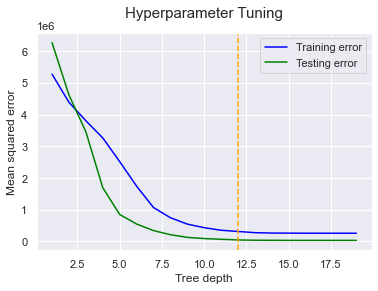

In [449]:
from sklearn.metrics import mean_squared_error as mse

max_depths = range(1, 20)
training_error = []

for max_depth in max_depths:
    model_1 = DecisionTreeRegressor(max_depth=max_depth)
    model_1.fit(X_train, Y_train)
    training_error.append(mse(Y_train, model_1.predict(X_train)))
    
testing_error = []
for max_depth in max_depths:
    model_2 = DecisionTreeRegressor(max_depth=max_depth)
    model_2.fit(x_test, y_test)
    testing_error.append(mse(y_test, model_2.predict(x_test)))

plt.plot(max_depths, training_error, color='blue', label='Training error')
plt.plot(max_depths, testing_error, color='green', label='Testing error')
plt.xlabel('Tree depth')
plt.axvline(x=12, color='orange', linestyle='--')
plt.ylabel('Mean squared error')
plt.title('Hyperparameter Tuning', pad=15, size=15)
plt.legend()
plt.savefig('error.png')

In [450]:
regr.score(x_test, y_test)

0.7095148024406142

#### Use Grid Search Cross Validation to find best hyperparameters

In [462]:
from sklearn.metrics import get_scorer_names
# get_scorer_names()

In [466]:
from sklearn.model_selection import GridSearchCV

model = DecisionTreeRegressor()

gs = GridSearchCV(model,
                  param_grid = {'max_depth': range(1, 20),
                                'min_samples_split': range(2, 60, 2)},
                  cv=5,
                  n_jobs=1,
                  scoring='neg_mean_squared_error')

gs.fit(X_train, Y_train)

print(gs.best_params_)
print(-gs.best_score_)

{'max_depth': 9, 'min_samples_split': 52}
4565762.777159015


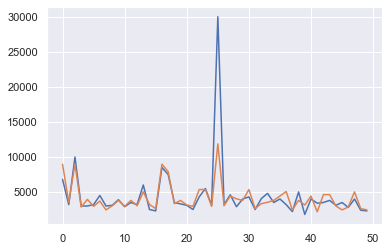

In [467]:
regr = DecisionTreeRegressor(max_depth=9, min_samples_split=52, criterion="squared_error")
regr.fit(X_train, Y_train)

# Predict
result = regr.predict(x_test.to_numpy())

# Plot results
plt.plot(y_test.to_numpy()[:50])
plt.plot(result[:50])
plt.show()


In [468]:
print(f"Training R2: {regr.score(X_train, Y_train)}\n")

print(f"R2: {regr.score(x_test, y_test)}")
print(f"MAE: {mean_absolute_error(y_test, result)}")
print(f"MSE: {mean_squared_error(y_test,result)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, result))}")

Training R2: 0.6695992673397672

R2: 0.6147390485950597
MAE: 1064.6027051054893
MSE: 5291303.504181703
RMSE: 2300.283353020167


With the **Decision Tree** model, we got accuracy of 61% (R2 = 0.61) and Mean Absoulte Error of 1064 (in average our model makes a prediction error of 1064 PLN. 

## Random Forest

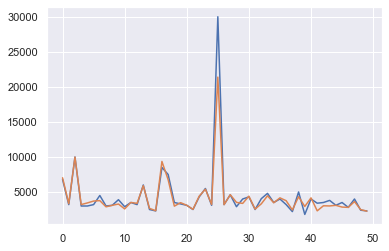

In [478]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
rfr.fit(X_train, Y_train)

result = rfr.predict(x_test.to_numpy())

# Plot results
plt.plot(y_test.to_numpy()[:50])
plt.plot(result[:50])
plt.show()

In [474]:
print(f"R2: {rfr.score(x_test, y_test)}")
print(f"MAE: {mean_absolute_error(y_test, result)}")
print(f"MSE: {mean_squared_error(y_test,result)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, result))}")

R2: 0.8296758898335707
MAE: 786.1530254977203
MSE: 2339288.62420055
RMSE: 1529.47331594917


## Use GridSeach Cross Validation to find best hyperparameters for Random Forest

In [188]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [i for i in range(2, 20, 1)],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5, 6, 8, 10, 12],
    'min_samples_split': [8, 10, 12, 15, 18, 20, 24],
    'n_estimators': [100, 200, 300, 1000, 2000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [156]:
# Fit the grid search to the data
grid_search.fit(X_train, Y_train)
grid_search.best_params_

Fitting 5 folds for each of 5390 candidates, totalling 26950 fits
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000; total time=   0.8s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200; total time

[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=2000; total time=   1.8s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000; total time=   0.9s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=2, 

[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   0.9s
[CV] END bootstrap=True, max_depth=100, max_features=2

[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=2000; total time=   1.6s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=1000; total time=   0.8s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=15, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=15, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=15, n_estimators=300; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=15, n_estimators=300; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=15, n_estimators=1000; total time=   0.8s
[CV] END bootstrap=True, max_depth=100, max_features

[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=8, min_samples_split=15, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=8, min_samples_split=15, n_estimators=300; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=8, min_samples_split=15, n_estimators=300; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=8, min_samples_split=15, n_estimators=1000; total time=   0.9s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=8, min_samples_split=15, n_estimators=2000; total time=   1.8s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=8, min_samples_split=18, n_estimators=2000; total time=   2.0s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=8, min_samples_split=20, n_estimators=2000; total time=   2.0s
[CV] END bootstrap=True, max_depth=100, max_feature

[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=15, n_estimators=1000; total time=   0.9s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=18, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=18, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=18, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=18, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=18, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=18, n_estimators=300; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, max_features=2

[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000; total time=   0.9s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=2000; total time=   1.7s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=2000; total time=   1.9s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=2000; total time=   1.8s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=15, n_estimators=2000; total time=   1.7s
[CV] END bootstrap=True, max_depth=100, max_features=2

[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=10, min_samples_split=15, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=10, min_samples_split=15, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=10, min_samples_split=15, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=10, min_samples_split=15, n_estimators=300; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=10, min_samples_split=15, n_estimators=1000; total time=   0.9s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=10, min_samples_split=15, n_estimators=2000; total time=   1.7s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=10, min_samples_split=18, n_estimators=2000; total time=   1.6s
[CV] END bootstrap=True, max_depth=100, max_f

[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=8, min_samples_split=24, n_estimators=2000; total time=   1.6s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=10, min_samples_split=8, n_estimators=2000; total time=   1.9s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=10, min_samples_split=10, n_estimators=1000; total time=   0.9s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=10, min_samples_split=12, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=10, min_samples_split=12, n_estimators=300; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=10, min_samples_split=12, n_estimators=300; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=10, min_samples_split=12, n_estimators=1000; total time=   0.9s
[CV] END bootstrap=True, max_depth=100, max_fe

[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=8, min_samples_split=15, n_estimators=300; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=8, min_samples_split=15, n_estimators=1000; total time=   0.8s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=8, min_samples_split=18, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=8, min_samples_split=18, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=8, min_samples_split=18, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=8, min_samples_split=18, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=8, min_samples_split=18, n_estimators=300; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, max_features=2

[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=10, min_samples_split=8, n_estimators=2000; total time=   1.6s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=10, min_samples_split=10, n_estimators=1000; total time=   1.0s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=10, min_samples_split=12, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=10, min_samples_split=12, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=10, min_samples_split=12, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=10, min_samples_split=12, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=10, min_samples_split=12, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_fea

[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=10, min_samples_split=18, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=10, min_samples_split=18, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=10, min_samples_split=18, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=10, min_samples_split=18, n_estimators=300; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=10, min_samples_split=18, n_estimators=1000; total time=   0.8s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=10, min_samples_split=18, n_estimators=2000; total time=   1.6s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=10, min_samples_split=20, n_estimators=1000; total time=   0.8s
[CV] END bootstrap=True, max_depth=100, max_f

[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=10, min_samples_split=20, n_estimators=2000; total time=   1.6s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=10, min_samples_split=24, n_estimators=1000; total time=   0.8s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=12, min_samples_split=8, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=12, min_samples_split=8, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=12, min_samples_split=8, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=12, min_samples_split=8, n_estimators=300; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=12, min_samples_split=8, n_estimators=300; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_feature

[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=12, min_samples_split=15, n_estimators=2000; total time=   1.7s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=12, min_samples_split=18, n_estimators=1000; total time=   0.9s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=12, min_samples_split=20, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=12, min_samples_split=20, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=12, min_samples_split=20, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=12, min_samples_split=20, n_estimators=300; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=12, min_samples_split=20, n_estimators=1000; total time=   0.8s
[CV] END bootstrap=True, max_depth=100, max_f

[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=12, min_samples_split=10, n_estimators=300; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=12, min_samples_split=10, n_estimators=300; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=12, min_samples_split=10, n_estimators=1000; total time=   0.8s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=12, min_samples_split=12, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=12, min_samples_split=12, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=12, min_samples_split=12, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=12, min_samples_split=12, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_fea

[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=18, n_estimators=300; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=18, n_estimators=1000; total time=   0.9s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=20, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=20, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=20, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=20, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=20, n_estimators=300; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=3

[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=24, n_estimators=1000; total time=   0.9s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=8, min_samples_split=8, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=8, min_samples_split=8, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=8, min_samples_split=8, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=8, min_samples_split=8, n_estimators=300; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=8, min_samples_split=8, n_estimators=300; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=8, min_samples_split=8, n_estimators=1000; total time=   0.9s
[CV] END bootstrap=True, max_depth=100, max_features=3, min

[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=300; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=300; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=1000; total time=   1.0s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=15, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=15, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=3

[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=12, min_samples_split=12, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=12, min_samples_split=12, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=12, min_samples_split=12, n_estimators=300; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=12, min_samples_split=12, n_estimators=300; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=12, min_samples_split=12, n_estimators=1000; total time=   0.9s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=12, min_samples_split=12, n_estimators=2000; total time=   1.8s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=12, min_samples_split=15, n_estimators=2000; total time=   1.8s
[CV] END bootstrap=True, max_depth=100, max_f

[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=2000; total time=   1.9s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=2000; total time=   1.9s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=15, n_estimators=1000; total time=   1.0s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=18, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=18, n_estimators=300; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=18, n_estimators=300; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=18, n_estimators=1000; total time=   0.9s
[CV] END bootstrap=True, max_depth=100, max_feature

KeyboardInterrupt: 

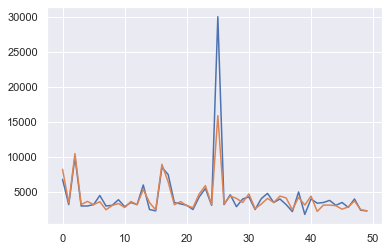

In [434]:
best_grid = RandomForestRegressor(bootstrap=True, 
                            max_depth=150, 
                            max_features=3, 
                            min_samples_leaf=3, 
                            min_samples_split=8, 
                            n_estimators=200)
best_grid.fit(X_train, Y_train)


result = best_grid.predict(x_test.to_numpy())

# Plot results
plt.plot(y_test.to_numpy()[:50])
plt.plot(result[:50])
plt.show()

In [332]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} .'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

# best_grid = grid_search.best_estimator_
# grid_accuracy = evaluate(best_grid, x_test, y_test)

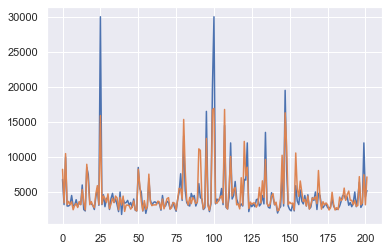

In [435]:
result = best_grid.predict(x_test.to_numpy())

# Plot results
plt.plot(y_test.to_numpy())
plt.plot(result)
plt.show()

In [436]:
print(f"R2: {best_grid.score(x_test, y_test)}")
print(f"MAE: {mean_absolute_error(y_test, result)}")
print(f"MSE: {mean_squared_error(y_test,result)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, result))}")

R2: 0.737730938290249
MAE: 908.5908409894049
MSE: 3602091.5179763967
RMSE: 1897.9176794519822


In [437]:
import joblib
joblib.dump(best_grid, "random_forest_houses.joblib", compress=3) 

['random_forest_houses.joblib']

### Sklearn Linear Regression

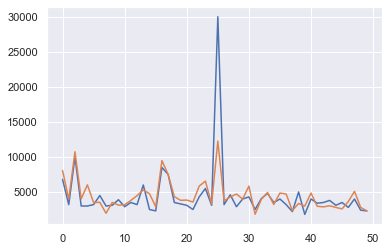

In [492]:
from sklearn.linear_model import LinearRegression
regr = LinearRegression()
regr.fit(X_train_norm, Y_train)

# Predict
x_test_norm = scaler.fit_transform(x_test)
result = regr.predict(x_test_norm)

# Plot results
plt.plot(y_test.to_numpy()[:50])
plt.plot(result[:50])
plt.show()

In [493]:
print(f"R2: {regr.score(x_test_norm, y_test)}")
print(f"MAE: {mean_absolute_error(y_test, result)}")
print(f"MSE: {mean_squared_error(y_test,result)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, result))}")

R2: 0.5882496009630866
MAE: 1251.2523622833514
MSE: 5655118.488720776
RMSE: 2378.049303256931


### Encode some new value and check it

In [490]:
district = enc.transform([["Bemowo"]])[0][0]
rooms = 1
sqm = 30
district

0.0

In [491]:
test_array = np.array([district, rooms, sqm])
rfr.predict([test_array])

array([2711.5])